In [1]:
#-------Import Dependencies-------#
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [2]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [3]:
def label_assignment(img,label):
    return label

def training_data(label,data_dir):
    for img in tqdm(os.listdir(data_dir)):
        label = label_assignment(img,label)
        path = os.path.join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [4]:
chihuahua_dir = '../input/images/Images/n02085620-Chihuahua'
japanese_spaniel_dir = '../input/images/Images/n02085782-Japanese_spaniel'
maltese_dir = '../input/images/Images/n02085936-Maltese_dog'
pekinese_dir = '../input/images/Images/n02086079-Pekinese'
shitzu_dir = '../input/images/Images/n02086240-Shih-Tzu'
blenheim_spaniel_dir = '../input/images/Images/n02086646-Blenheim_spaniel'
papillon_dir = '../input/images/Images/n02086910-papillon'
toy_terrier_dir = '../input/images/Images/n02087046-toy_terrier'
afghan_hound_dir = '../input/images/Images/n02088094-Afghan_hound'
basset_dir = '../input/images/Images/n02088238-basset'


X = []
Z = []
imgsize = 150

In [5]:
training_data('chihuahua',chihuahua_dir)
training_data('japanese_spaniel',japanese_spaniel_dir)
training_data('maltese',maltese_dir)
training_data('pekinese',pekinese_dir)
training_data('shitzu',shitzu_dir)
training_data('blenheim_spaniel',blenheim_spaniel_dir)
training_data('papillon',papillon_dir)
training_data('toy_terrier',toy_terrier_dir)
training_data('afghan_hound',afghan_hound_dir)
training_data('basset',basset_dir)

100%|██████████| 175/175 [00:01<00:00, 152.50it/s]


In [6]:
label_encoder= LabelEncoder()
Y = label_encoder.fit_transform(Z)
Y = to_categorical(Y,10)
X = np.array(X)
X=X/255

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.3,random_state=69)

In [7]:
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

augs_gen.fit(x_train)

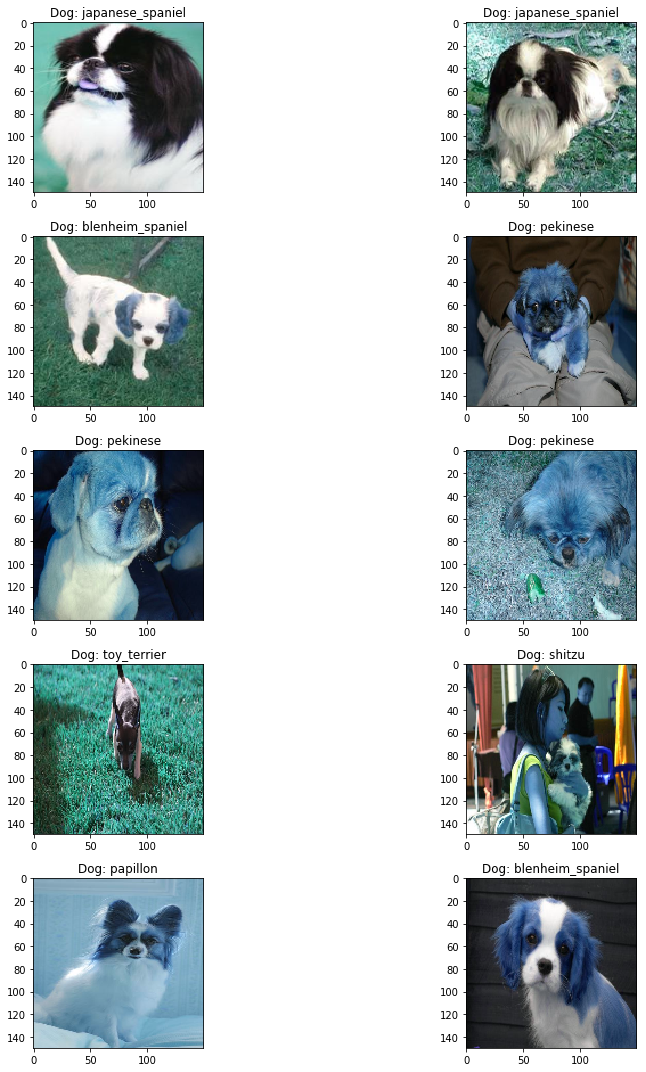

In [8]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Dog: '+Z[l])
        
plt.tight_layout()

In [9]:
base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(10,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

58892288/58889256 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f1c102ea8d0> False
<keras.layers.convolutional.Conv2D object at 0x7f1c1030aac8> False
<keras.layers.convolutional.Conv2D object at 0x7f1c1030a780> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1c1038a320> False
<keras.layers.convolutional.Conv2D object at 0x7f1c1038a4e0> False
<keras.layers.convolutional.Conv2D object at 0x7f1c10283668> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1c1021c240> False
<keras.layers.convolutional.Conv2D object at 0x7f1c1021ceb8> False
<keras.layers.convolutional.Conv2D object at 0x7f1c1024c2e8> False
<keras.layers.convolutional.Conv2D object at 0x7f1c101e50f0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1c10202550> False
<keras.layers.convolutional.Conv2D object at 0x7f1c10219080> False
<keras.layers.convolutional.Conv2D object at 0x7f1c101b6390> False
<keras.layers.convolutional.Conv2D object at 0x7f1c101d2128> F

In [10]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [11]:
#-----------Optimizers-----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)
#----------Compile---------------#
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#-----------Training------------#
history = model.fit_generator(
    augs_gen.flow(x_train,y_train,batch_size=16),
    validation_data  = (x_test,y_test),
    validation_steps = 1000,
    steps_per_epoch  = 1000,
    epochs = 20, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/20
1000/1000 [==============================] - 75s 75ms/step - loss: 1.8138 - acc: 0.3900 - val_loss: 1.3594 - val_acc: 0.5737

Epoch 00001: val_loss improved from inf to 1.35936, saving model to ./base.model
Epoch 2/20
1000/1000 [==============================] - 74s 74ms/step - loss: 1.4254 - acc: 0.5353 - val_loss: 1.1730 - val_acc: 0.6153

Epoch 00002: val_loss improved from 1.35936 to 1.17297, saving model to ./base.model
Epoch 3/20
1000/1000 [==============================] - 73s 73ms/step - loss: 1.3224 - acc: 0.5683 - val_loss: 1.1268 - val_acc: 0.6239

Epoch 00003: val_loss improved from 1.17297 to 1.12681, saving model to ./base.model
Epoch 4/20
1000/1000 [==============================] - 73s 73ms/step - loss: 1.2556 - acc: 0.5781 - val_loss: 1.1008 - val_acc: 0.6291

Epoch 00004: val_loss improved from 1.12681 to 1.10083, saving model to ./base.model
Epoch 5/20
1000/1000 [==============================] - 73s 73ms/step - loss: 1.2319 - acc: 0.5867 - val_loss: 1.061

577/577 [==============================] - 1s 2ms/step
Model Test Loss: 0.9971365714816948
Model Test Accuracy: 0.6412478336221837
Weights Saved


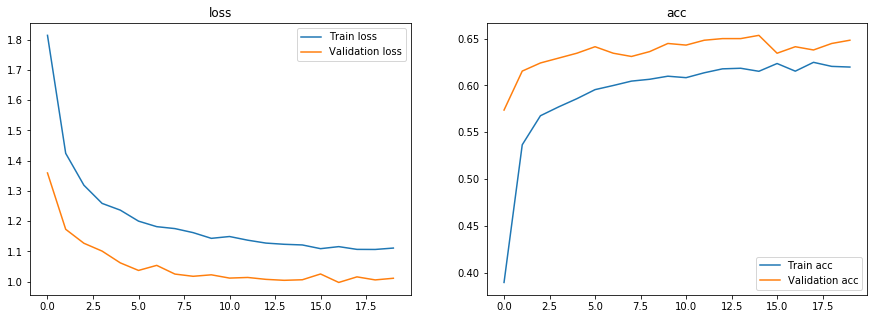

In [12]:
show_final_history(history)
model.load_weights('./base.model')
model_score = model.evaluate(x_test,y_test)
print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])

model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")

In [13]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = './logs' # Here you have to put your log directory
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 8080 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 8080 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2023-10-22 07:14:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 54.237.133.81, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
ERROR: The certificate of ‘bin.equinox.io’ is not trusted.
ERROR: The certificate of ‘bin.equinox.io’ has expired.
unzip:  cannot find or open ngrok-stable-linux-amd64.zip, ngrok-stable-linux-amd64.zip.zip or ngrok-stable-linux-amd64.zip.ZIP.
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/conda/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/opt/conda/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/opt/conda/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/opt/conda/lib/python3.6/json